In [1]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# ─── Global Settings ─────────────────────────────────────────────
TOP_N = 3                   # default number of classes to show
HEATMAP_THRESHOLD = 0.2     # threshold (fraction of max) for CAM mask
BOX_LINE_WIDTH = 2
CENTER_RADIUS = 5
CAM_OPACITY = 0.4           # heatmap overlay opacity

In [3]:
# ─── Model & Hooks ──────────────────────────────────────────────
model = models.resnet50(pretrained=True)
model.eval()
target_layer = model.layer4[-1]

activations = gradients = None
def forward_hook(m, inp, out):
    global activations
    activations = out.detach()
def backward_hook(m, grad_in, grad_out):
    global gradients
    gradients = grad_out[0].detach()

target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

C:\Users\hedge\.conda\envs\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hedge\.conda\envs\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# ─── Preprocessing & Labels ─────────────────────────────────────
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])
with open("imagenet_classes.txt") as f:
    idx2label = [l.strip() for l in f]

def load_image(path):
    img = Image.open(path).convert("RGB")
    return img, preprocess(img).unsqueeze(0)

In [5]:
# ─── Grad‑CAM Computation ───────────────────────────────────────
def compute_gradcam(input_tensor, class_idx):
    global activations, gradients
    # Forward + backward for class_idx
    logits = model(input_tensor)
    model.zero_grad()
    logits[0, class_idx].backward(retain_graph=True)

    # αᶜₖ = global avg pool of gradients
    weights = gradients.mean(dim=[0,2,3], keepdim=True)  # shape (1,C,1,1)
    cam = F.relu((weights * activations).sum(dim=1)).squeeze()
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)
    return cam.cpu().numpy()

In [6]:
# ─── BBox + Center Extraction ───────────────────────────────────
def extract_bbox_and_center(cam, threshold=HEATMAP_THRESHOLD):
    H, W = cam.shape
    mask = (cam >= threshold).astype(np.uint8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask)
    if num_labels <= 1:
        return None, None
    areas = stats[1:, cv2.CC_STAT_AREA]
    idx = areas.argmax() + 1
    x, y, w, h, _ = stats[idx]
    ys, xs = np.where(labels == idx)
    cx, cy = xs.mean(), ys.mean()
    return (x, y, x+w, y+h), (cx, cy)


In [7]:
# ─── Visualization ──────────────────────────────────────────────
def overlay_heatmap_on_image(orig, cam):
    """Return PIL.Image of heatmap overlay only."""
    orig_np = np.array(orig)
    H, W = orig_np.shape[:2]
    cam_resized = cv2.resize(cam, (W, H))
    heatmap = cv2.applyColorMap(np.uint8(255*cam_resized), cv2.COLORMAP_JET)
    overlay = (heatmap * CAM_OPACITY + orig_np * (1-CAM_OPACITY)).astype(np.uint8)
    return Image.fromarray(overlay)

def draw_boxes_and_centers(orig, cams, topn):
    """Draw boxes, centers, and labels (at center) on a copy of orig PIL.Image."""
    img = orig.copy()
    draw = ImageDraw.Draw(img)
    font = ImageFont.load_default()
    W, H = img.size

    for cam, (cls, score) in zip(cams, topn):
        cam_resized = cv2.resize(cam, (W, H))
        bbox, center = extract_bbox_and_center(cam_resized)
        if bbox is None: continue
        x0, y0, x1, y1 = bbox
        cx, cy = center

        # draw bounding box
        draw.rectangle([x0, y0, x1, y1], outline="red", width=BOX_LINE_WIDTH)
        # draw center point
        draw.ellipse([cx - CENTER_RADIUS, cy - CENTER_RADIUS,
                      cx + CENTER_RADIUS, cy + CENTER_RADIUS],
                     fill="blue")

        # prepare label
        label = f"{idx2label[cls]} {score:.2f}"
        text_bbox = draw.textbbox((0, 0), label, font=font)
        text_w, text_h = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]

        # position label beside center point (adjust if close to edge)
        tx = min(max(cx + 10, 0), W - text_w)
        ty = min(max(cy - text_h / 2, 0), H - text_h)

        # draw label box and text
        # draw.rectangle([tx, ty, tx + text_w, ty + text_h])
        draw.text((tx, ty), label, fill="red", font=font)

    return img



C:\Users\hedge\.conda\envs\myenv\Lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)



Top 3 Predicted Classes:
  - Labrador retriever             (class 208) : 0.6820
  - golden retriever               (class 207) : 0.1781
  - kuvasz                         (class 222) : 0.0512


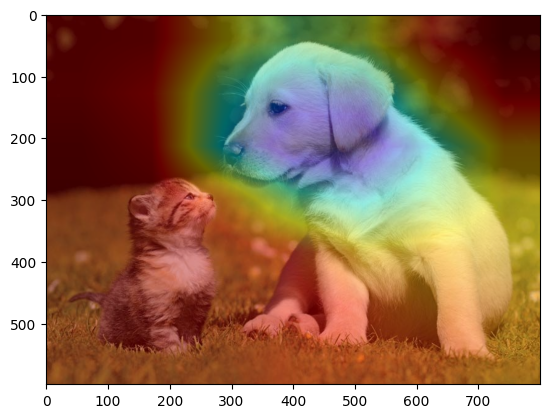

In [8]:
# ─── Main Routine ───────────────────────────────────────────────

TOP_N = 3                   # default number of classes to show
HEATMAP_THRESHOLD = 0.2  


img_path = "catdog.jpg"
orig, inp = load_image(img_path)
# forward to get top-n
logits = model(inp)
probs = F.softmax(logits, dim=1)[0]
topn = [(int(i), float(probs[i])) for i in probs.argsort(descending=True)[:TOP_N]]

print(f"\nTop {TOP_N} Predicted Classes:")
for cls_idx, prob in topn:
    print(f"  - {idx2label[cls_idx]:<30} (class {cls_idx}) : {prob:.4f}")
        
# compute CAMs
cams = [compute_gradcam(inp, cls) for cls,_ in topn]

# show heatmaps
for idx, cam in zip(topn, cams):
    hm = overlay_heatmap_on_image(orig, cam)
    plt.imshow(hm)
    # hm.show(title=f"CAM: {idx2label[idx[0]]} {idx[1]:.2f}")




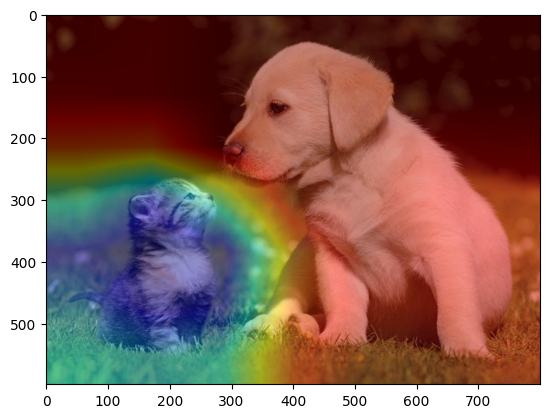

In [17]:
# 281 corresponds to "tabby"
cam = compute_gradcam(inp, 281 ) 

hm = overlay_heatmap_on_image(orig, cam)
plt.imshow(hm)


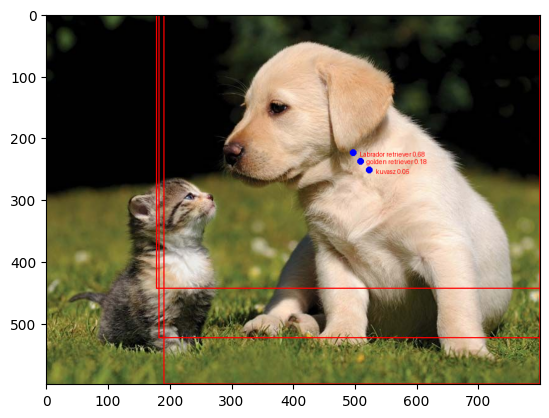

In [10]:
# draw boxes + centers + labels
boxed = draw_boxes_and_centers(orig, cams, topn)
boxed.show(title="Grad-CAM + BBoxes")
plt.imshow(boxed)
# boxed.save("gradcam_bboxes.png")
plt.show()